In [13]:
using MLDatasets
using Colors
using ImageShow
using LinearAlgebra
using Statistics
using Plots
using BSON: @save, @load
using JuMP
import HiGHS
import Ipopt

data = MNIST()

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [15]:
function mySVM(X,y)
    # model = Model(HiGHS.Optimizer)
    model = Model(Ipopt.Optimizer)

    set_silent(model)
    
    d,n = size(X)
    @variable(model, w[1:d])
    @variable(model, b)
    @constraint(model, [i in 1:n], y[i]*(transpose(w)*X[:,i]-b)≥1)
    @objective(model, Min, transpose(w)*w)
    optimize!(model)
    return value.(w),value(b)
end

function decision(x,w,b)
    return sign(dot(x,w)-b)
end

decision (generic function with 1 method)

In [16]:
function kernelMatrix(X,k)
    n = size(X,2)
    K = zeros(n,n)
    for i=1:n
        for j=1:n 
            K[i,j] = k(X[:,i],X[:,j])
        end
    end
    return K
end

function myKernelSVM(X,y,k)
    model2 = Model(Ipopt.Optimizer)
    set_silent(model2)
    n = size(X,2)

    @variable(model2, α[1:n])
    @variable(model2, b)
    
    K = kernelMatrix(X,k)

    @constraint(model2, [i in 1:n], y[i]*(transpose(α)*K[:,i]-b)≥1)
    @objective(model2, Min, transpose(α)*K*α)
    optimize!(model2)
    return value.(α),value(b)
end

function kernelDecision(x,X,k,α,b)
    n = size(X,2)
    r = sum(α[l]*k(X[:,l],x) for l=1:n) - b
    return sign(r)
end

kernelDecision (generic function with 1 method)

In [17]:
n = size(data.features,3)
y = data.targets

function getNumber(k)
    X = []
    for i = 1:n
        if y[i] == k
            push!(X,data.features[:,:,i])
        end
    end
    return X
end

function getNumber(a,b)
    X = []
    for i = 1:n
        if y[i] == a || y[i] == b
            push!(X,data.features[:,:,i])
        end
    end
    return X
end

getNumber (generic function with 2 methods)

In [18]:
function principalNumber(k)
    X = getNumber(k)
    m = length(X)
    Z = zeros(28^2,m)
    for j = 1:m
        Z[:,j] = X[j][:]
    end
    return Z
end

function principalNumber2(a,b)
    X = getNumber(a,b)
    m = length(X)
    Z = zeros(28^2,m)
    for j = 1:m
        Z[:,j] = X[j][:]
    end
    return Z
end

principalNumber2 (generic function with 1 method)

In [19]:
function testSVM(number1,number2,n1,n2)
    R1 = principalNumber(number1)
    s1 = size(R1,2)
    R2 = principalNumber(number2)
    s2 = size(R2,2)
    
    T1 = R1[:,1:n1]
    T2 = R2[:,1:n2]
    T = [T1 T2]
    L = zeros(n1+n2)
    L[1:n1] .= 1
    L[n1+1:end] .= -1
    w,b = mySVM(T,L)
    
    
    a1 = 0
    a2 = 0
    for j = 1:s1
        a1 = a1+max(0,decision(R1[:,j],w,b))
    end
    for j = 1:s2
        a2 = a2-min(0,decision(R2[:,j],w,b))
    end
    return a1/s1,a2/s2
end

testSVM (generic function with 1 method)

In [20]:
function testkernelSVM(number1,number2,n1,n2,k)
    R1 = principalNumber(number1)
    s1 = size(R1,2)
    R2 = principalNumber(number2)
    s2 = size(R2,2)
    
    T1 = R1[:,1:n1]
    T2 = R2[:,1:n2]
    T = [T1 T2]
    L = zeros(n1+n2)
    L[1:n1] .= 1
    L[n1+1:end] .= -1
    α,b = myKernelSVM(T,L,k)
    
    
    a1 = 0
    a2 = 0
    for j = 1:s1
        a1 = a1+max(0,kernelDecision(R1[:,j],T,k,α,b))
    end
    for j = 1:s2
        a2 = a2-min(0,kernelDecision(R2[:,j],T,k,α,b))
    end
    return a1/s1,a2/s2
end

testkernelSVM (generic function with 1 method)

In [21]:
k(x,y) = exp(-norm(x-y)^2/100)
# k(x,y) = dot(x,y)^2
# k(x,y) = exp(dot(x,y))

N = 50
number1 = 2
number2 = 8

display(testSVM(number1,number2,N,N))
testkernelSVM(number1,number2,N,N,k)

(0.9395770392749244, 0.9668432746539053)

(0.9560255119167506, 0.9600068364382157)

(784, 11809)


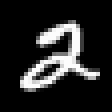

In [22]:
R = principalNumber2(number1,number2)
m = size(R,2)
println(size(R))

M = reshape(R,28,28,m)
convert2image(data,M[:,:,1])


In [23]:
using Interact:@manipulate
R1 = principalNumber(number1)
s1 = size(R1,2)
R2 = principalNumber(number2)
s2 = size(R2,2)
    
    T1 = R1[:,1:N]
    T2 = R2[:,1:N]
    T = [T1 T2]
    L = zeros(N+N)
    L[1:N] .= 1
    L[N+1:end] .= -1
    α,b = myKernelSVM(T,L,k)

@manipulate for s=1:m÷100
    u = kernelDecision(R[:,s],T,k,α,b)
    if u == 1 print(number1) else print(number2) end
    convert2image(data,M[:,:,s])
end

2

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["s"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 118, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(59), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/Users/martinehler/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/Users/martinehler/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/Users/martinehler/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/Users/martinehler/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/Users/martinehler/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000290081fb0, Task (runnable) @0x0000000290081fb0), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 5447783440, 1)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",

82822288228222882822828228222228288288222288822888822822282288882288822228828828222228228282282822282888222282228222882228888282288828882888282222288